In [1]:
! pip install feature_engine

     |████████████████████████████████| 176 kB 5.1 MB/s 
     |████████████████████████████████| 9.5 MB 50.5 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
from datetime import datetime as dt2
from datetime import timedelta as td
from datetime import time as tm

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

import plotly.offline as pyoff
import plotly.graph_objs as go

import feature_engine
from feature_engine.outliers import Winsorizer

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.metrics import davies_bouldin_score

import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_excel('../datasets/Online Retail.xlsx')

In [5]:
df.head()

InvoiceNo StockCode  ... CustomerID         Country
0    536365    85123A  ...    17850.0  United Kingdom
1    536365     71053  ...    17850.0  United Kingdom
2    536365    84406B  ...    17850.0  United Kingdom
3    536365    84029G  ...    17850.0  United Kingdom
4    536365    84029E  ...    17850.0  United Kingdom

[5 rows x 8 columns]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [7]:
df.describe()

Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000

In [8]:
df.nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

In [9]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [10]:
df.Country.value_counts(normalize=True) 

United Kingdom          0.914320
Germany                 0.017521
France                  0.015790
EIRE                    0.015124
Spain                   0.004674
Netherlands             0.004375
Belgium                 0.003818
Switzerland             0.003694
Portugal                0.002803
Australia               0.002323
Norway                  0.002004
Italy                   0.001482
Channel Islands         0.001399
Finland                 0.001283
Cyprus                  0.001148
Sweden                  0.000853
Unspecified             0.000823
Austria                 0.000740
Denmark                 0.000718
Japan                   0.000661
Poland                  0.000629
Israel                  0.000548
USA                     0.000537
Hong Kong               0.000531
Singapore               0.000423
Iceland                 0.000336
Canada                  0.000279
Greece                  0.000269
Malta                   0.000234
United Arab Emirates    0.000125
European C

In [11]:
df = df[df.Country == 'United Kingdom']

In [12]:
df = df[df.Quantity > 0]

In [13]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceYearMonth'] = df['InvoiceDate'].map(lambda date: 100*date.year + date.month)
df['Date'] = df['InvoiceDate'].dt.strftime('%Y-%m')

In [14]:
print(df["InvoiceDate"].min())
print(df["InvoiceDate"].max())
print("The data is from 1 year transaction")

2010-12-01 08:26:00
2011-12-09 12:49:00
The data is from 1 year transaction


In [15]:
df = df[df.UnitPrice > 0]

In [16]:
df = df[pd.notnull(df['CustomerID'])]

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354321 entries, 0 to 541893
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   InvoiceNo         354321 non-null  object        
 1   StockCode         354321 non-null  object        
 2   Description       354321 non-null  object        
 3   Quantity          354321 non-null  int64         
 4   InvoiceDate       354321 non-null  datetime64[ns]
 5   UnitPrice         354321 non-null  float64       
 6   CustomerID        354321 non-null  float64       
 7   Country           354321 non-null  object        
 8   InvoiceYearMonth  354321 non-null  int64         
 9   Date              354321 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 29.7+ MB


In [81]:
df_agg= df.groupby("Date").Quantity.sum()
df_agg.head()

Date
2010-12-01    21310
2010-12-02    30988
2010-12-03     7648
2010-12-05    13659
2010-12-06    15535
Name: Quantity, dtype: int64

In [19]:
df_agg=pd.DataFrame(df_agg)
df_agg=df_agg.reset_index()
df_agg.head()

Date  Quantity
0  2010-12    267767
1  2011-01    278251
2  2011-02    213375
3  2011-03    276304
4  2011-04    260448

In [20]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Quantity', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.plot(x, y, color='tab:Blue', marker='o')
    plt.show()

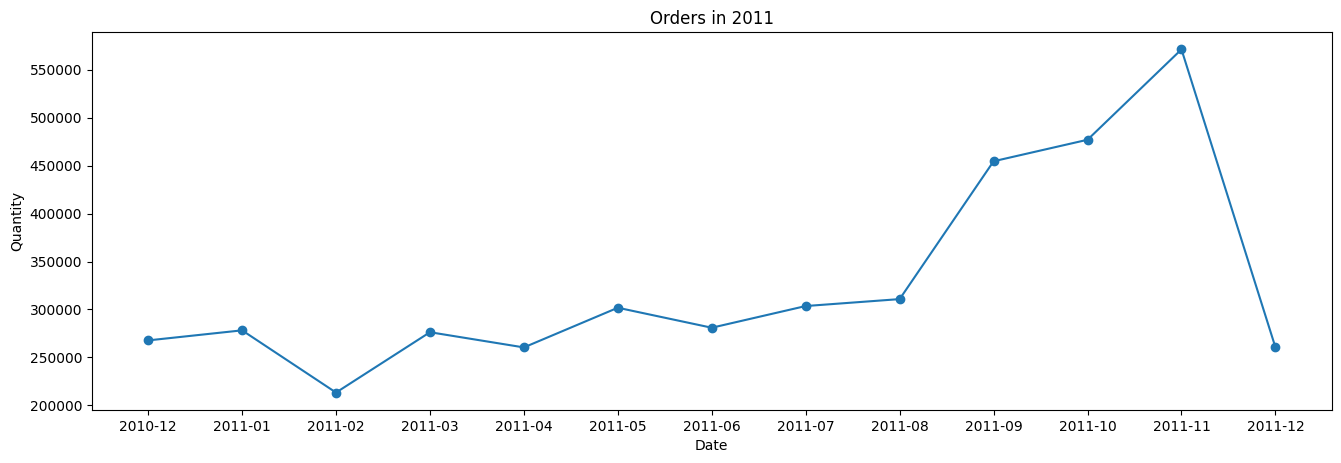

In [21]:
plot_df(df_agg, x=df_agg.Date, y=df_agg.Quantity,title='Orders in 2011')

In [22]:
df['Revenue'] = df['Quantity']*df['UnitPrice']

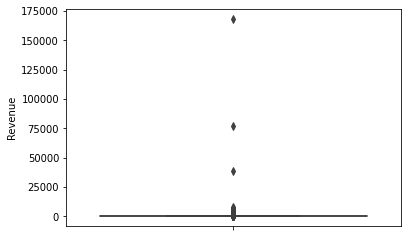

In [23]:
sns.boxplot(y=df['Revenue'])

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354321 entries, 0 to 541893
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   InvoiceNo         354321 non-null  object        
 1   StockCode         354321 non-null  object        
 2   Description       354321 non-null  object        
 3   Quantity          354321 non-null  int64         
 4   InvoiceDate       354321 non-null  datetime64[ns]
 5   UnitPrice         354321 non-null  float64       
 6   CustomerID        354321 non-null  float64       
 7   Country           354321 non-null  object        
 8   InvoiceYearMonth  354321 non-null  int64         
 9   Date              354321 non-null  object        
 10  Revenue           354321 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(5)
memory usage: 32.4+ MB


In [83]:
df_revenue = df.groupby(['InvoiceYearMonth'])['Revenue'].sum().reset_index()
df_revenue.head()

InvoiceYearMonth     Revenue
0            201012  498661.850
1            201101  442190.060
2            201102  355655.630
3            201103  467198.590
4            201104  409559.141

In [ ]:
plot_data = [
    go.Scatter(
        x=df_revenue['InvoiceYearMonth'],
        y=df_revenue['Revenue'],
        mode='lines+markers'
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Montly Revenue'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [27]:
NOW = dt.date(2011,12,9) 
df['Date'] = pd.DatetimeIndex(df.InvoiceDate).date

In [28]:
df_recency = df.groupby(['CustomerID'],as_index=False)['Date'].max()
df_recency.columns = ['CustomerID','Last_Purchase_Date']

df_recency['Recency'] = df_recency.Last_Purchase_Date.apply(lambda x:(NOW - x).days)
df_recency.drop(columns=['Last_Purchase_Date'],inplace=True)
df_recency.head()

CustomerID  Recency
0     12346.0      325
1     12747.0        2
2     12748.0        0
3     12749.0        3
4     12820.0        3

In [29]:
FM_Table = df.groupby('CustomerID').agg({'InvoiceNo'   : lambda x:len(x),
                                         'Revenue'  : lambda x:x.sum()})
FM_Table.rename(columns = {'InvoiceNo' :'Frequency',
                           'Revenue':'Monetary'},inplace= True)
FM_Table.head()

Frequency  Monetary
CustomerID                     
12346.0             1  77183.60
12747.0           103   4196.01
12748.0          4595  33719.73
12749.0           199   4090.88
12820.0            59    942.34

In [30]:
RFM_Table = df_recency.merge(FM_Table,left_on='CustomerID',right_on='CustomerID')
RFM_Table.head()

CustomerID  Recency  Frequency  Monetary
0     12346.0      325          1  77183.60
1     12747.0        2        103   4196.01
2     12748.0        0       4595  33719.73
3     12749.0        3        199   4090.88
4     12820.0        3         59    942.34

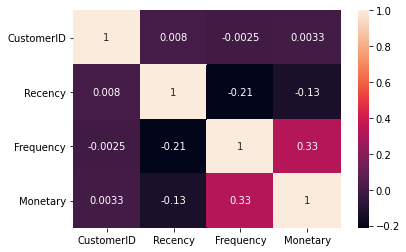

In [31]:
sns.heatmap(RFM_Table.corr(), annot=True);

In [32]:
quantiles = RFM_Table.quantile(q=[0.25,0.50,0.75])
quantiles = quantiles.to_dict()

In [33]:
segmented_rfm = RFM_Table.copy()

In [34]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [35]:
segmented_rfm['R_quartile'] = segmented_rfm['Recency'].apply(RScore, args=('Recency',quantiles))
segmented_rfm['F_quartile'] = segmented_rfm['Frequency'].apply(FMScore, args=('Frequency',quantiles))
segmented_rfm['M_quartile'] = segmented_rfm['Monetary'].apply(FMScore, args=('Monetary',quantiles))
segmented_rfm.head()

CustomerID  Recency  Frequency  Monetary  R_quartile  F_quartile  M_quartile
0     12346.0      325          1  77183.60           4           4           1
1     12747.0        2        103   4196.01           1           1           1
2     12748.0        0       4595  33719.73           1           1           1
3     12749.0        3        199   4090.88           1           1           1
4     12820.0        3         59    942.34           1           2           2

In [36]:
segmented_rfm['RFM_Segment'] = segmented_rfm.R_quartile.map(str)+segmented_rfm.F_quartile.map(str)+segmented_rfm.M_quartile.map(str)

In [38]:
segmented_rfm['RFM_Score'] = segmented_rfm[['R_quartile','F_quartile','M_quartile']].sum(axis=1)

In [39]:
segmented_rfm.head()

CustomerID  Recency  Frequency  ...  M_quartile  RFM_Segment  RFM_Score
0     12346.0      325          1  ...           1          441          9
1     12747.0        2        103  ...           1          111          3
2     12748.0        0       4595  ...           1          111          3
3     12749.0        3        199  ...           1          111          3
4     12820.0        3         59  ...           2          122          5

[5 rows x 9 columns]

In [40]:
print("Best Customers: ",len(segmented_rfm[segmented_rfm['RFM_Segment']=='111']))
print('Loyal Customers: ',len(segmented_rfm[segmented_rfm['F_quartile']==1]))
print("Big Spenders: ",len(segmented_rfm[segmented_rfm['M_quartile']==1]))
print('Almost Lost: ', len(segmented_rfm[segmented_rfm['RFM_Segment']=='134']))
print('Lost Customers: ',len(segmented_rfm[segmented_rfm['RFM_Segment']=='344']))
print('Lost Cheap Customers: ',len(segmented_rfm[segmented_rfm['RFM_Segment']=='444']))

Best Customers:  409
Loyal Customers:  980
Big Spenders:  980
Almost Lost:  21
Lost Customers:  168
Lost Cheap Customers:  343


In [41]:
label = [0] * len(segmented_rfm)

for i in range(0,len(segmented_rfm)):

    if segmented_rfm['RFM_Segment'][i] == '111':
        label[i] = "Best Customers"
        
    elif segmented_rfm['RFM_Segment'][i] == '134' :
        label[i] = "Almost Lost"
        
    elif segmented_rfm['RFM_Segment'][i] == '344':
        label[i] = "Lost Customers"
    
    elif segmented_rfm['RFM_Segment'][i] == '444':
        label[i] = "Lost Cheap Customers"

    elif segmented_rfm['F_quartile'][i] == 1:
        label[i] = "Loyal Customers"  
    
    elif segmented_rfm['M_quartile'][i] == 1:
        label[i] = "Big Spenders"   
        
    else:
        label[i] = "Others"

In [42]:
segmented_rfm['Label'] = label

In [43]:
segmented_rfm['Label'].value_counts()

Others                  2135
Loyal Customers          571
Best Customers           409
Lost Cheap Customers     343
Big Spenders             273
Lost Customers           168
Almost Lost               21
Name: Label, dtype: int64

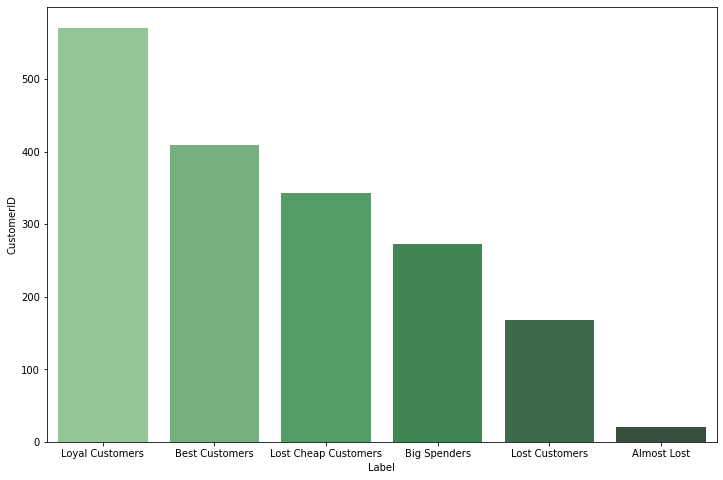

In [44]:
import seaborn as sns
sq1=segmented_rfm.groupby('Label')['CustomerID'].nunique().sort_values(ascending=False).reset_index()
plt.figure(figsize=(12,8))
sq1.drop([0],inplace=True)
sns.barplot(data=sq1, x="Label", y="CustomerID", palette = "Greens_d");

In [45]:
RFM_Table_New = RFM_Table.drop('CustomerID', axis=1)

In [46]:
RFM_Table_New.head()

Recency  Frequency  Monetary
0      325          1  77183.60
1        2        103   4196.01
2        0       4595  33719.73
3        3        199   4090.88
4        3         59    942.34

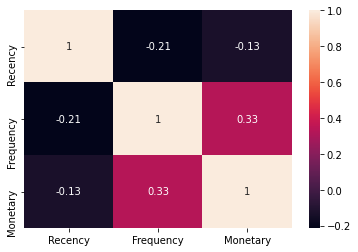

In [47]:
sns.heatmap(RFM_Table_New.corr(), annot=True);

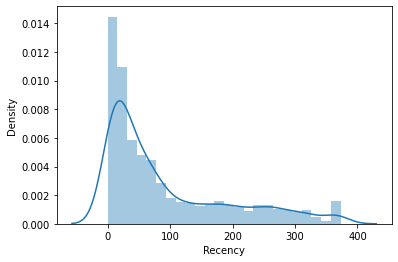

In [48]:
sns.distplot(RFM_Table_New['Recency'])

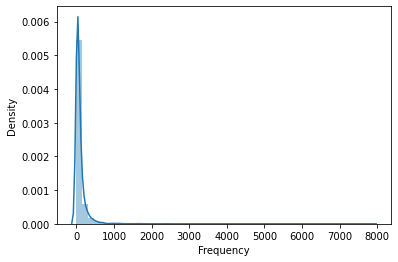

In [49]:
sns.distplot(RFM_Table_New['Frequency'])

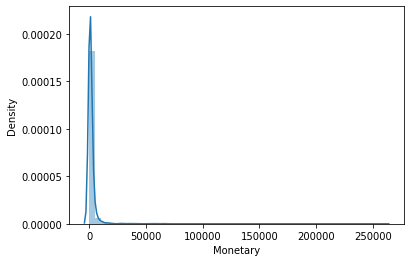

In [50]:
sns.distplot(RFM_Table_New['Monetary'])

In [51]:
df_rfm_log = RFM_Table_New.copy()
df_rfm_log.head()

Recency  Frequency  Monetary
0      325          1  77183.60
1        2        103   4196.01
2        0       4595  33719.73
3        3        199   4090.88
4        3         59    942.34

In [52]:
df_rfm_log = np.log(df_rfm_log+1)

In [53]:
windsoriser = Winsorizer(tail='both',
                          fold=2,
                           variables=[ 'Recency', 'Frequency', 'Monetary']
                        )
windsoriser.fit(df_rfm_log)

Winsorizer(capping_method='gaussian', fold=2, missing_values='raise',
           tail='both', variables=['Recency', 'Frequency', 'Monetary'])

In [54]:
df_rfm_log = windsoriser.transform(df_rfm_log)

In [55]:
scaler = StandardScaler()
scaler.fit(df_rfm_log)
RFM_Table_New_scaled = scaler.transform(df_rfm_log)

In [56]:
RFM_Table_New_scaled = pd.DataFrame(RFM_Table_New_scaled, columns=RFM_Table_New.columns)
RFM_Table_New_scaled.head()

Recency  Frequency  Monetary
0  1.465297  -2.075758  2.144403
1 -2.017919   0.758484  1.551824
2 -2.065875   2.073202  2.144403
3 -1.804182   1.296742  1.530081
4 -1.804182   0.305732  0.272393

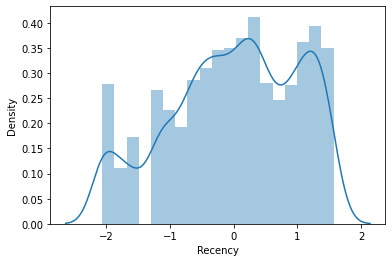

In [57]:
sns.distplot(RFM_Table_New_scaled['Recency'])

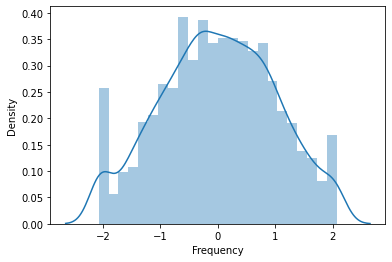

In [58]:
sns.distplot(RFM_Table_New_scaled['Frequency'])

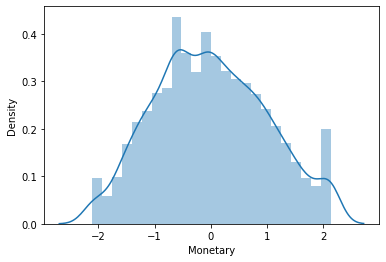

In [59]:
sns.distplot(RFM_Table_New_scaled['Monetary'])

In [60]:
X = np.asarray(RFM_Table_New_scaled)

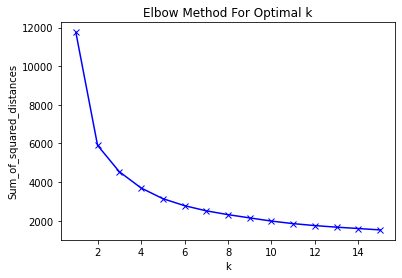

In [61]:
Sum_of_squared_distances = []
K = range(1,16)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [62]:
def kmeans(normalised_df_rfm, clusters_number, original_df_rfm):
    
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(normalised_df_rfm)

    cluster_labels = kmeans.labels_
        
    df_new = original_df_rfm.assign(Cluster = cluster_labels)
    
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new

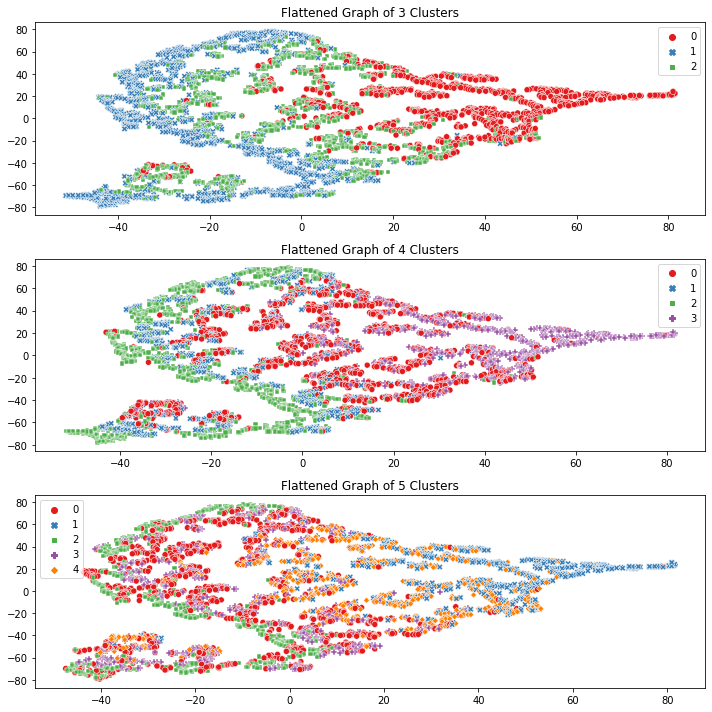

In [63]:
plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
df_rfm_k3 = kmeans(RFM_Table_New_scaled, 3, RFM_Table)

plt.subplot(3, 1, 2)
df_rfm_k4 = kmeans(RFM_Table_New_scaled, 4, RFM_Table)

plt.subplot(3, 1, 3)
df_rfm_k5 = kmeans(RFM_Table_New_scaled, 5, RFM_Table)

plt.tight_layout()


In [64]:
def snake_plot(normalised_df_rfm, df_rfm_kmeans, df_rfm_original):

    normalised_df_rfm = pd.DataFrame(normalised_df_rfm, 
                                       index=RFM_Table.index, 
                                       columns=RFM_Table.columns)
    normalised_df_rfm['Cluster'] = df_rfm_kmeans['Cluster']

    df_melt = pd.melt(normalised_df_rfm.reset_index(), 
                        id_vars=['CustomerID', 'Cluster'],
                        value_vars=['Recency', 'Frequency', 'Monetary'], 
                        var_name='Metric', 
                        value_name='Value')

    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Metric', y='Value', hue='Cluster')
    
    return

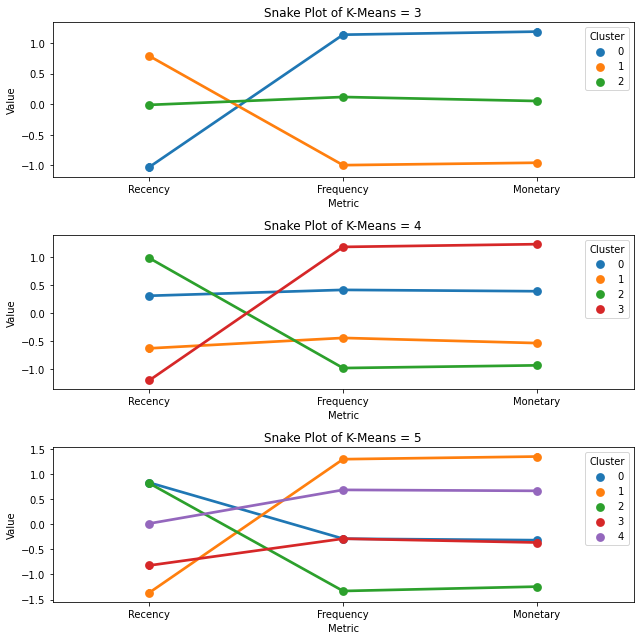

In [65]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
plt.title('Snake Plot of K-Means = 3')
snake_plot(RFM_Table_New_scaled, df_rfm_k3, RFM_Table)

plt.subplot(3, 1, 2)
plt.title('Snake Plot of K-Means = 4')
snake_plot(RFM_Table_New_scaled, df_rfm_k4, RFM_Table)

plt.subplot(3, 1, 3)
plt.title('Snake Plot of K-Means = 5')
snake_plot(RFM_Table_New_scaled, df_rfm_k5, RFM_Table)

plt.tight_layout()

In [67]:
print(davies_bouldin_score(X, kmeans.labels_))

1.1226066820122775


In [68]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [69]:
print(davies_bouldin_score(X, kmeans.labels_))

1.0658152650181372


In [70]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [71]:
print(davies_bouldin_score(X, kmeans.labels_))

1.0702106938696923


In [72]:
df_rfm_k4.head()

CustomerID  Recency  Frequency  Monetary  Cluster
0     12346.0      325          1  77183.60        0
1     12747.0        2        103   4196.01        3
2     12748.0        0       4595  33719.73        3
3     12749.0        3        199   4090.88        3
4     12820.0        3         59    942.34        3

In [73]:
df_rfm_k4.Cluster.value_counts()

2    1168
0    1130
3     853
1     769
Name: Cluster, dtype: int64

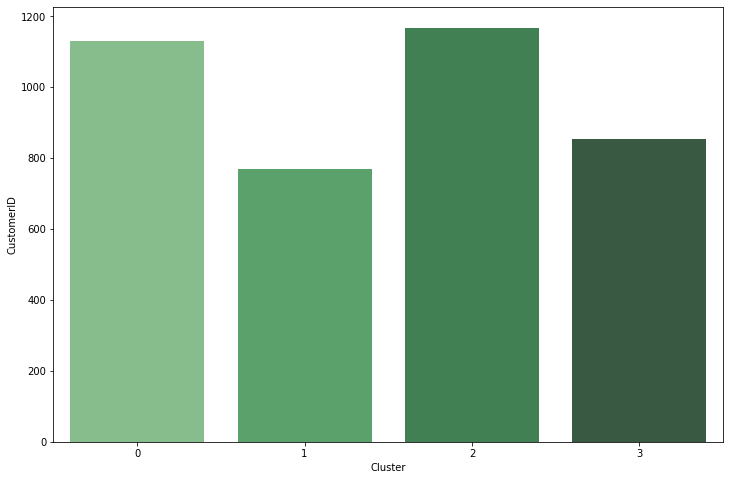

In [74]:
import seaborn as sns
sq1=df_rfm_k4.groupby('Cluster')['CustomerID'].nunique().sort_values(ascending=False).reset_index()
plt.figure(figsize=(12,8))
sns.barplot(data=sq1, x="Cluster", y="CustomerID", palette = "Greens_d");

In [75]:
def rfm_values(df):

    df_new = df.groupby(['Cluster']).agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': ['mean', 'count']
    }).round(0)
    
    return df_new

In [76]:
rfm_values(df_rfm_k4)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0          89.0      81.0   1449.0  1130
1          25.0      30.0    461.0   769
2         197.0      15.0    294.0  1168
3          12.0     260.0   5830.0   853